https://hongl.tistory.com/99
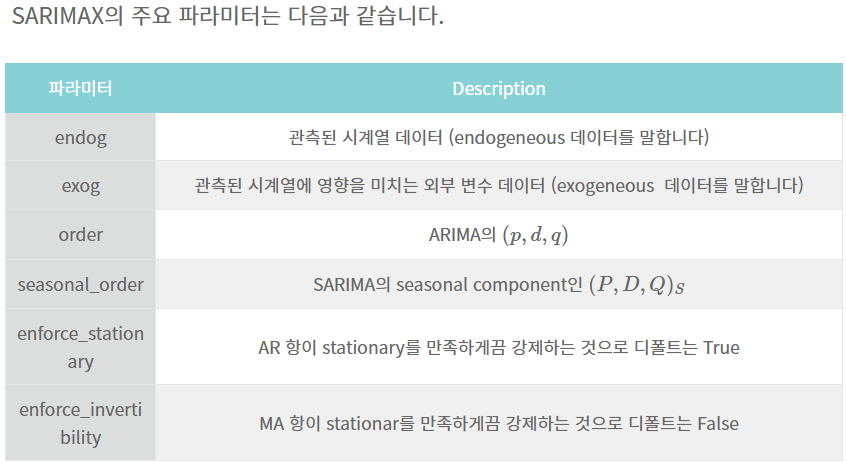

### 1. 필요한 라이브러리 미리 다운 pip install --user pmdarima
### 2. 날짜(dates)와 y변수만 있는 csv 데이터만 입력
### 3. null 존재 x

- 정상성/비정상성 반환 함수
- 정상성 변환 함수
- 아리마 적용 함수

In [ ]:
## pmdarima 설치 
pip install --user pmdarima

In [ ]:
## 필요한 라이브러리 불러오기
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pmdarima.arima import auto_arima
from pmdarima.arima import ndiffs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
## 데이터 가져오기

path = input()
data = pd.read_csv(path)
print('< 원본 >')
data

In [ ]:
## 날짜로 인덱스 설정

data = data.set_index('dates', drop=True)
print('< 인덱스 설정 >')
data

In [ ]:
## 데이터 나누기

split = int(0.7*len(data)) #7:3 비율

train = data[:split] #학습
test = data[split:] #예측

In [ ]:
## 정상성 확인 adf pvalue 반환

def adf_test(dt):
    stat, p_value, lags, nobs, crit, icb = adfuller(dt)
    print('p_value :', p_value)
    return p_value

In [ ]:
p_v = adf_test(train) #pvalue 저장

In [ ]:
## 차분 횟수 변수

d = 0

In [ ]:
## 정상성 변환

if p_v > 0.05:
    kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)
    
    print('n_diffs :', n_diffs)
    
    if n_diffs>0:
        d = n_diffs
        
        diff_train = train.diff(d)
        
        diff_train = diff_train.dropna(axis=0)
        
        diff_p_v = adf_test(diff_train)
        print('diff p_value :', diff_p_v) #대부분 여기서 0.05 이하로 나오지 않을까
        
        if diff_p_v > 0.05: #분산 일정x 경우
            log_train = np.log(diff_train) 
            # 오류해결방법..
            # RuntimeWarning: invalid value encountered in log result = func(self.values, **kwargs)
            #
            
            log_train = log_train.dropna(axis=0)

            log_p_v = adf_test(log_train)
            print('log p_value :', log_p_v) 
            
            plt.plot(log_train)
            plt.show()               
            
            if ((log_p_v) > 0.05): #이건
                print('?????????????????????????')
            else:
                print('good')

In [ ]:
## auto_arima
'''
train_auto_arima = auto_arima(y = train        # 데이터
                      , d = d            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = True # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True      # stepwise로 모델을 적합할 때마다 결과를 프린트
                      )
'''

In [ ]:
def autoarima(train):
    
    model = 0
    ex = 99999 
    m = 1
    
    for m_test in [1, 7, 12]: #52까지 하면 웹꺼짐..추가 입력을 받자..
        arima = auto_arima(
                    y = train, 
                    d = d, 
                    m = m_test, 
                    seasonal = True, 
                    trace = True
                )
        if arima.aic() < ex:
            ex = arima.aic()
            models = arima
            m = m_test
            
    return [models, m]

In [ ]:
model, m = autoarima(train)